<a href="https://colab.research.google.com/github/BerhanDemiralp/Coupon-Recommendation/blob/main/coupon_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    roc_auc_score,
    average_precision_score,
    f1_score
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
DATA_PATH = "in-vehicle-coupon-recommendation.csv"  # <-- burayı kendi dosya adına göre ayarla
TARGET = "Y"

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())
print("\nColumns:", df.columns.tolist())


Shape: (12684, 26)


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0



Columns: ['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus', 'has_children', 'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y']


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
destination,12684,3,No Urgent Place,6283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passanger,12684,4,Alone,7305,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,12684,3,Sunny,10069,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temperature,12684.0,NaN,NaN,NaN,63.301798,19.154486,30.0,55.0,80.0,80.0,80.0
time,12684,5,6PM,3230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coupon,12684,5,Coffee House,3996,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expiration,12684,2,1d,7091,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,12684,2,Female,6511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,12684,8,21,2653,NaN,NaN,NaN,NaN,NaN,NaN,NaN
maritalStatus,12684,5,Married partner,5100,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0
car,0.991485
CoffeeHouse,0.017108
Restaurant20To50,0.014901
CarryAway,0.011905
RestaurantLessThan20,0.010249
Bar,0.008436
weather,0.000000
temperature,0.000000
destination,0.000000
passanger,0.000000


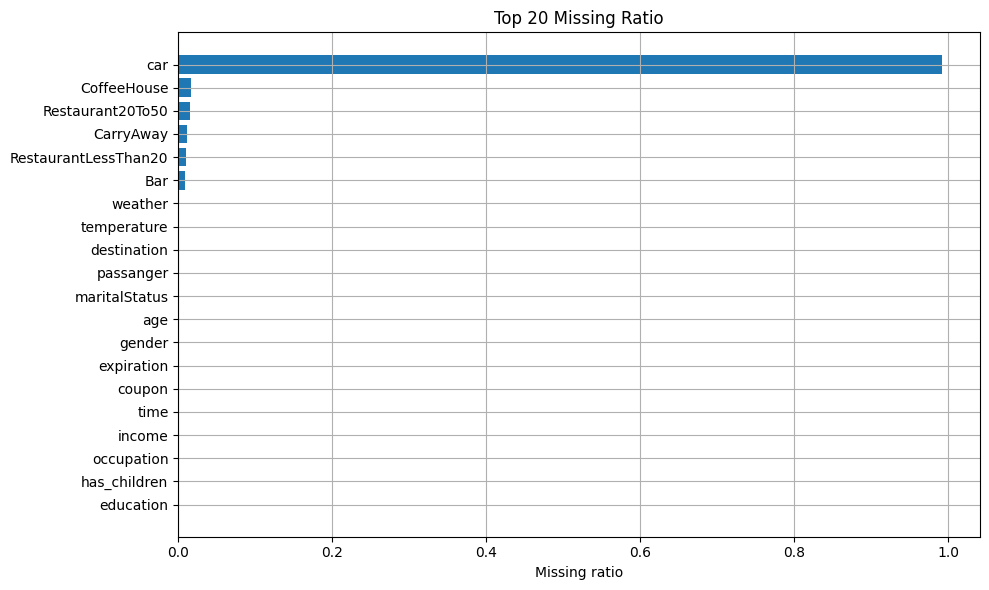

In [4]:
display(df.describe(include="all").T.head(30))

missing_ratio = df.isna().mean().sort_values(ascending=False)
display(missing_ratio.head(20))

# Missingness bar plot (top 20)
topk = 20
mr = missing_ratio.head(topk).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(mr.index, mr.values)
plt.title(f"Top {topk} Missing Ratio")
plt.xlabel("Missing ratio")
plt.tight_layout()
plt.show()


Y
0    5474
1    7210
Name: count, dtype: int64


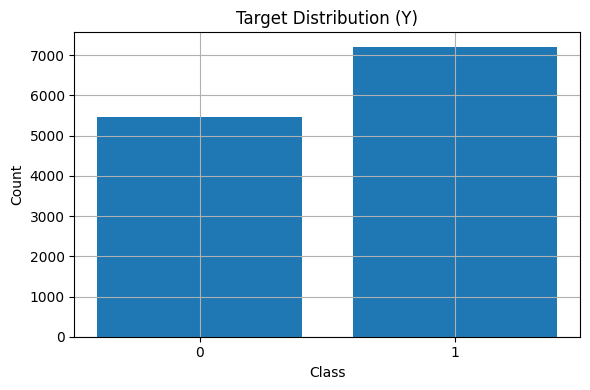

Positive rate: 0.5684326710816777


In [5]:
y_counts = df[TARGET].value_counts().sort_index()
print(y_counts)

plt.figure(figsize=(6,4))
plt.bar(y_counts.index.astype(str), y_counts.values)
plt.title("Target Distribution (Y)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("Positive rate:", (df[TARGET] == 1).mean())


,Y
coupon,
Carry out & Take away,0.735478
Restaurant(<20),0.707107
Coffee House,0.499249
Restaurant(20-50),0.441019
Bar,0.410015


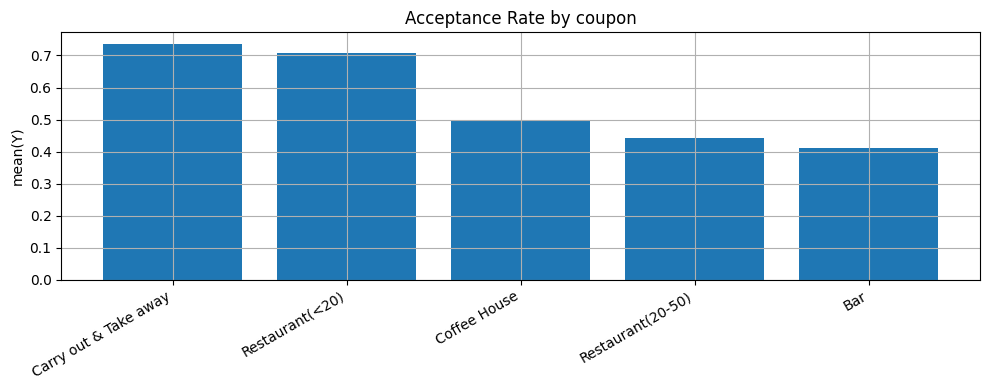

In [6]:
if "coupon" in df.columns:
    acc_by_coupon = df.groupby("coupon")[TARGET].mean().sort_values(ascending=False)
    display(acc_by_coupon)

    plt.figure(figsize=(10,4))
    plt.bar(acc_by_coupon.index.astype(str), acc_by_coupon.values)
    plt.title("Acceptance Rate by coupon")
    plt.ylabel("mean(Y)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("coupon kolonu bulunamadı (dataset sürümünü kontrol et).")


Numeric cols: ['temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp']


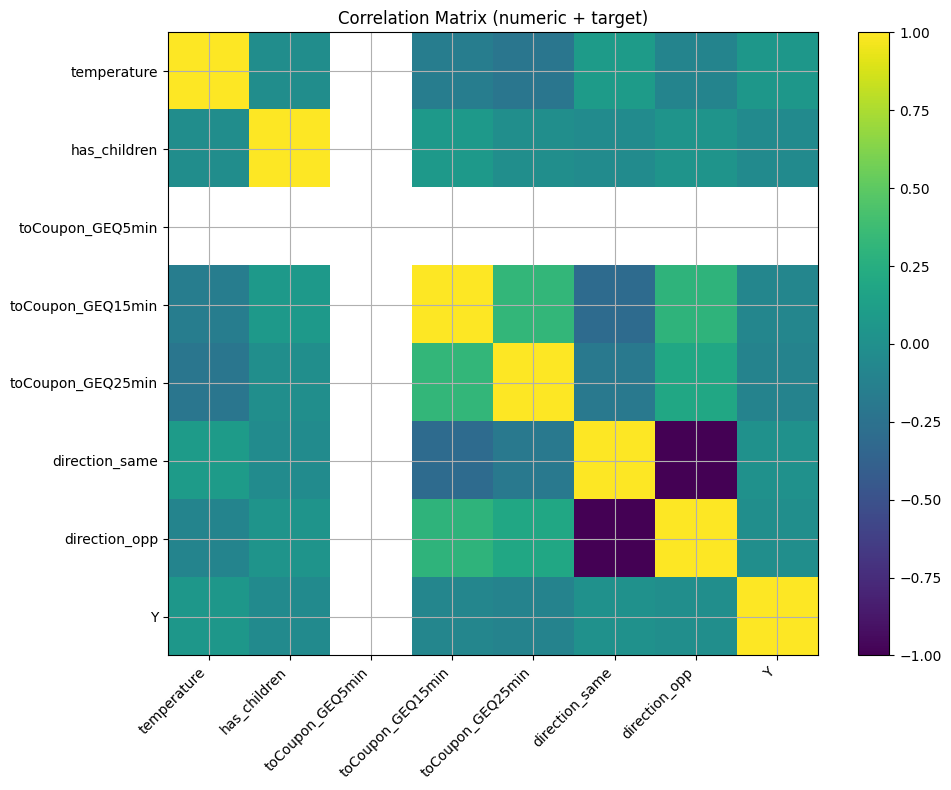

,Y
toCoupon_GEQ25min,-0.103633
toCoupon_GEQ15min,-0.081602
temperature,0.061240
has_children,-0.045557
direction_same,0.014570
direction_opp,-0.014570
toCoupon_GEQ5min,NaN


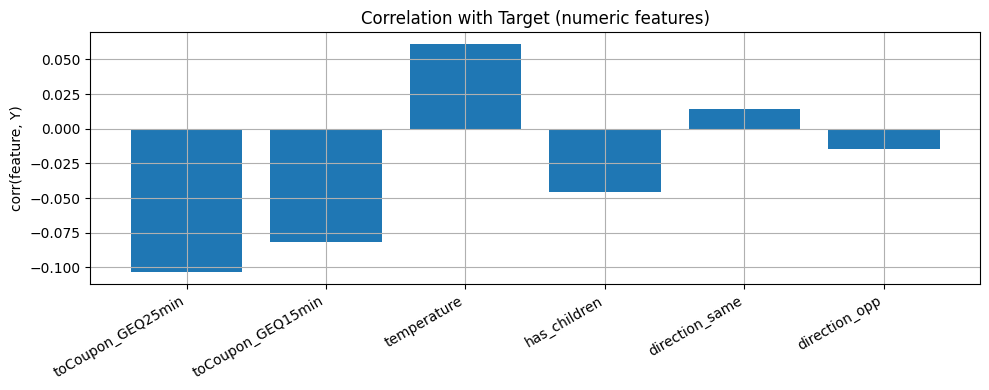

In [7]:
numeric_cols_all = df.select_dtypes(include=["int64","int32","float64","float32"]).columns.tolist()
numeric_cols_all = [c for c in numeric_cols_all if c != TARGET]

print("Numeric cols:", numeric_cols_all)

if len(numeric_cols_all) > 0:
    corr = df[numeric_cols_all + [TARGET]].corr(numeric_only=True)

    plt.figure(figsize=(10, 8))
    plt.imshow(corr.values, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation Matrix (numeric + target)")
    plt.tight_layout()
    plt.show()

    # Target ile numeric korelasyonlarını sırala
    corr_to_target = corr[TARGET].drop(TARGET).sort_values(key=np.abs, ascending=False)
    display(corr_to_target)

    plt.figure(figsize=(10,4))
    plt.bar(corr_to_target.index.astype(str), corr_to_target.values)
    plt.title("Correlation with Target (numeric features)")
    plt.ylabel("corr(feature, Y)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Numeric feature yok ya da bulunamadı.")


Shown categorical columns: ['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration']


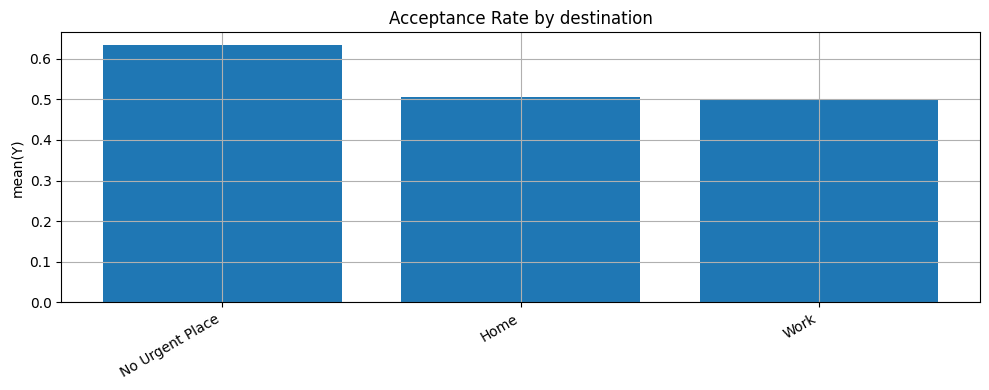

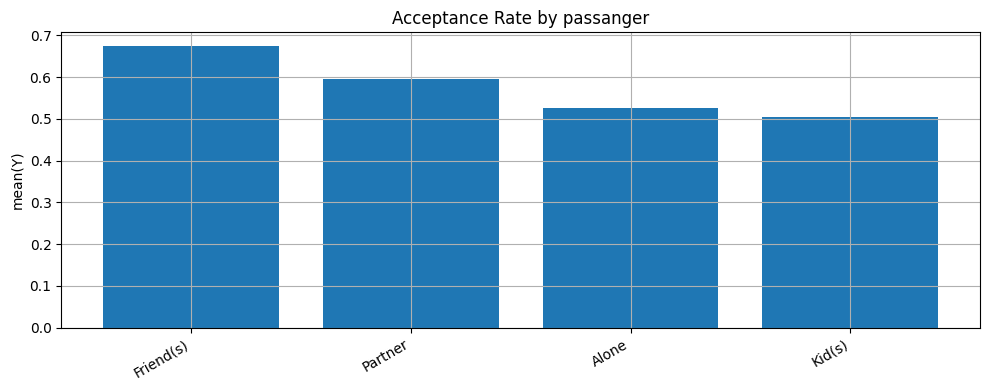

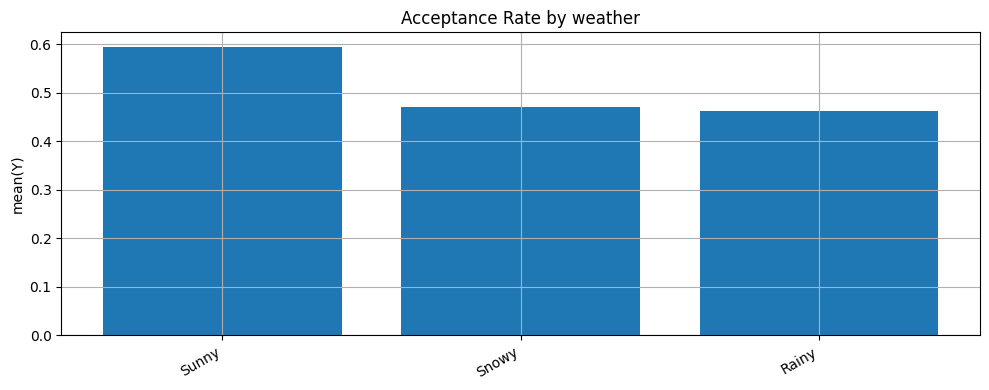

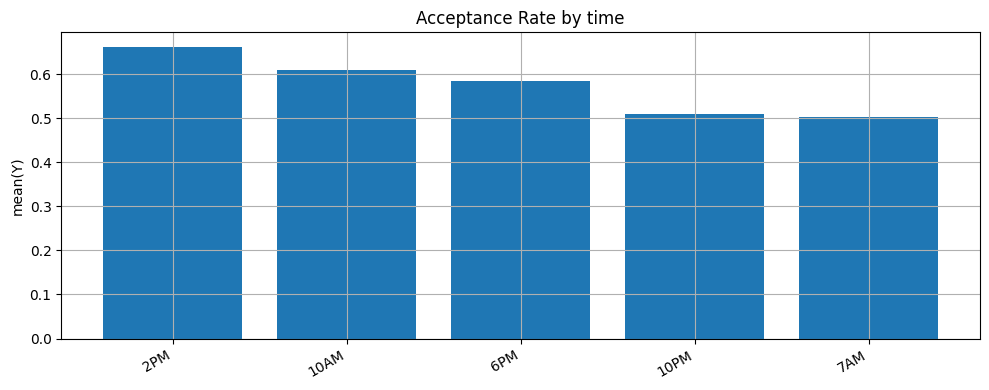

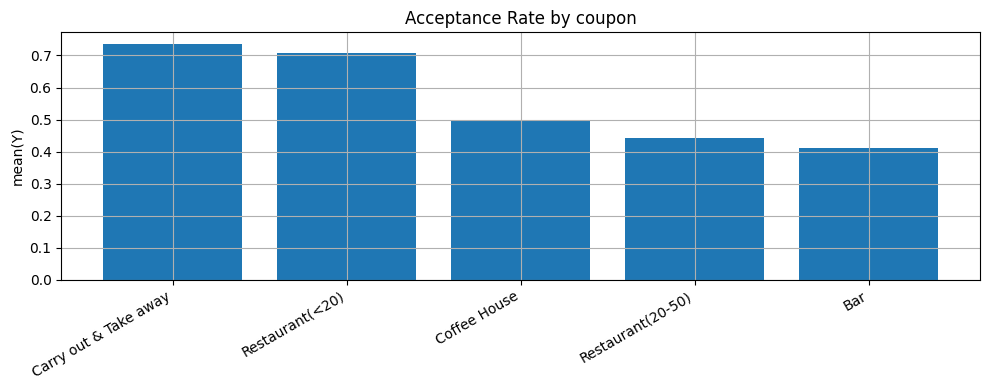

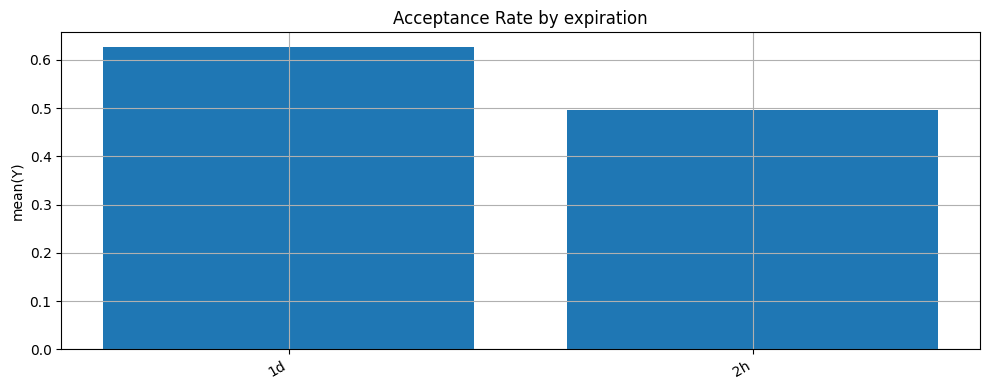

In [8]:
# Bazı aday kategorik kolonlar
candidate_cat = [c for c in df.columns if c not in numeric_cols_all + [TARGET]]

# Çok yüksek kardinalitesi olmayan ilk birkaç kolonla gösterim
show_cols = []
for c in candidate_cat:
    nunique = df[c].nunique(dropna=True)
    if 2 <= nunique <= 15:  # ayarlanabilir
        show_cols.append(c)
    if len(show_cols) >= 6:
        break

print("Shown categorical columns:", show_cols)

for c in show_cols:
    rates = df.groupby(c)[TARGET].mean().sort_values(ascending=False)
    plt.figure(figsize=(10,4))
    plt.bar(rates.index.astype(str), rates.values)
    plt.title(f"Acceptance Rate by {c}")
    plt.ylabel("mean(Y)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


In [9]:
X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].astype(int).copy()

# car çok boş ise drop
if "car" in X.columns:
    mr_car = X["car"].isna().mean()
    print("car missing ratio:", mr_car)
    if mr_car > 0.95:
        X = X.drop(columns=["car"])
        print("car dropped (>95% missing)")

# age bazen kategorik gibi davranır (sürümden sürüme değişebilir)
if "age" in X.columns:
    X["age"] = X["age"].astype(str)

# Train/Test split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

# Column types
numeric_cols = X_train.select_dtypes(include=["int64","int32","float64","float32"]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Numeric:", len(numeric_cols), "Categorical:", len(categorical_cols))


car missing ratio: 0.9914853358561968
car dropped (>95% missing)
Train shape: (10147, 24) Test shape: (2537, 24)
Numeric: 7 Categorical: 17


In [10]:
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_preprocess_sparse = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

# LR & SVC gibi modeller sparse ile iyi çalışır
preprocess_sparse = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_cols),
        ("cat", categorical_preprocess_sparse, categorical_cols)
    ],
    remainder="drop"
)

# RandomForest genelde dense ister/tercih eder -> dense onehot
categorical_preprocess_dense = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess_dense = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_cols),
        ("cat", categorical_preprocess_dense, categorical_cols)
    ],
    remainder="drop"
)


In [11]:
def eval_on_test(model, X_te, y_te, title):
    y_pred = model.predict(X_te)

    # score for ROC/PR
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_te)[:, 1]
    else:
        # CalibratedClassifierCV -> predict_proba var, yoksa decision_function
        y_score = model.decision_function(X_te)

    f1 = f1_score(y_te, y_pred)
    roc = roc_auc_score(y_te, y_score)
    pr  = average_precision_score(y_te, y_score)

    print("\n" + "="*80)
    print(title)
    print(f"F1={f1:.4f} | ROC-AUC={roc:.4f} | PR-AUC={pr:.4f}")
    print(classification_report(y_te, y_pred, digits=4, zero_division=0))

    ConfusionMatrixDisplay.from_predictions(y_te, y_pred)
    plt.title(f"{title} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

    RocCurveDisplay.from_predictions(y_te, y_score)
    plt.title(f"{title} - ROC Curve")
    plt.tight_layout()
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_te, y_score)
    plt.title(f"{title} - PR Curve")
    plt.tight_layout()
    plt.show()

    return {"model": title, "f1": f1, "roc_auc": roc, "pr_auc": pr}

Buradaki sonuçlar örnek gösterim içindir. En iyi modelin seçilmesinde CrossValidation kullanılmıştır.


İşleniyor: DummyClassifier (most_frequent)...

DummyClassifier (most_frequent)
F1=0.7248 | ROC-AUC=0.5000 | PR-AUC=0.5684
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1095
           1     0.5684    1.0000    0.7248      1442

    accuracy                         0.5684      2537
   macro avg     0.2842    0.5000    0.3624      2537
weighted avg     0.3231    0.5684    0.4120      2537



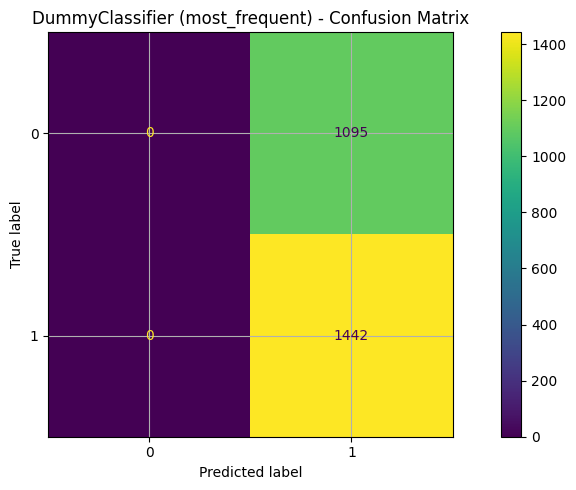

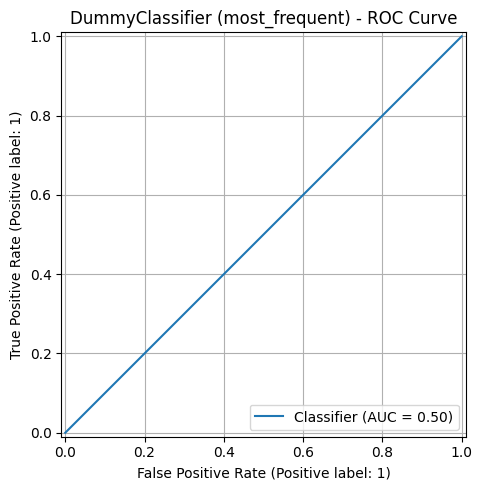

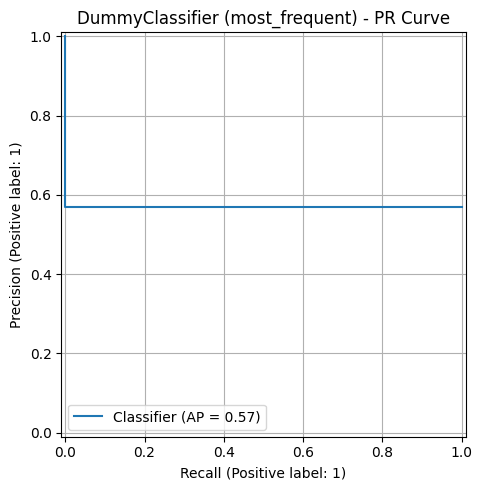

--- DummyClassifier (most_frequent) Sonucu ---


,model,f1,roc_auc,pr_auc
0,DummyClassifier (most_frequent),0.724805,0.5,0.568388


In [12]:
name_dummy = "DummyClassifier (most_frequent)"
print(f"\nİşleniyor: {name_dummy}...")

dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)

dummy.fit(X_train, y_train)
result_dummy = eval_on_test(dummy, X_test, y_test, name_dummy)


print(f"--- {name_dummy} Sonucu ---")
display(pd.DataFrame([result_dummy]))

In [13]:
logistic_regression_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=3000)
lr = Pipeline(steps=[
    ("preprocess", preprocess_sparse),
    ("model", logistic_regression_model)
])

print("Logistic Regression pipeline 'lr' created.")

Logistic Regression pipeline 'lr' created.


işleniyor: LogisticRegression (base)...

LogisticRegression (base)
F1=0.7338 | ROC-AUC=0.7317 | PR-AUC=0.7648
              precision    recall  f1-score   support

           0     0.6521    0.5598    0.6025      1095
           1     0.6982    0.7732    0.7338      1442

    accuracy                         0.6811      2537
   macro avg     0.6752    0.6665    0.6681      2537
weighted avg     0.6783    0.6811    0.6771      2537



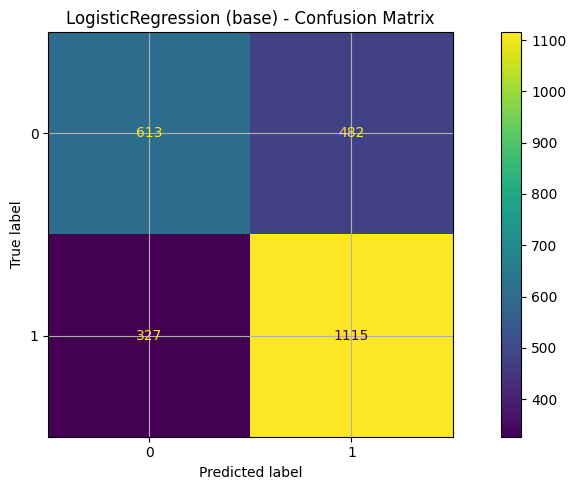

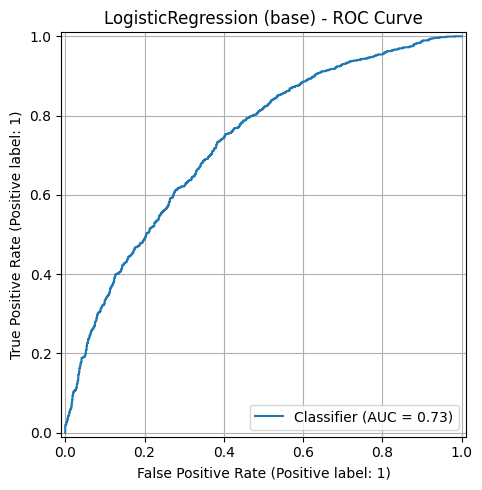

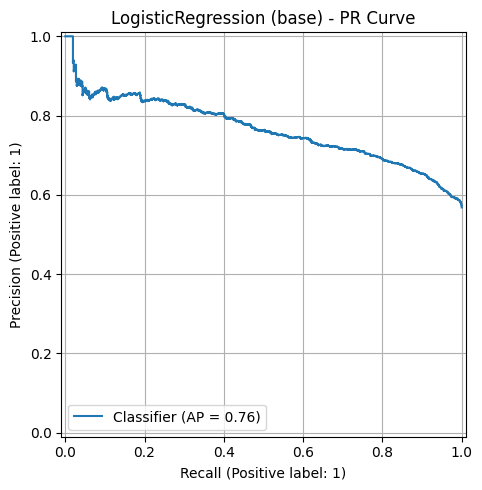

--- LogisticRegression (base) Sonucu ---


,model,f1,roc_auc,pr_auc
0,LogisticRegression (base),0.733794,0.731705,0.764806


In [14]:
name_lr = "LogisticRegression (base)"
print(f"işleniyor: {name_lr}...")

# Eğit ve Test Et
lr.fit(X_train, y_train)
result_lr = eval_on_test(lr, X_test, y_test, name_lr)

# Sadece bu modelin sonucunu göster
print(f"--- {name_lr} Sonucu ---")
display(pd.DataFrame([result_lr]))

In [15]:
linear_svc_model = LinearSVC(random_state=RANDOM_STATE, dual=False, max_iter=3000)
svc = Pipeline(steps=[
    ("preprocess", preprocess_sparse),
    ("model", CalibratedClassifierCV(estimator=linear_svc_model, cv=3))
])

print("LinearSVC pipeline 'svc' created.")

LinearSVC pipeline 'svc' created.



İşleniyor: LinearSVC + CalibratedClassifierCV (base)...

LinearSVC + CalibratedClassifierCV (base)
F1=0.7374 | ROC-AUC=0.7328 | PR-AUC=0.7652
              precision    recall  f1-score   support

           0     0.6587    0.5516    0.6004      1095
           1     0.6969    0.7829    0.7374      1442

    accuracy                         0.6831      2537
   macro avg     0.6778    0.6673    0.6689      2537
weighted avg     0.6804    0.6831    0.6783      2537



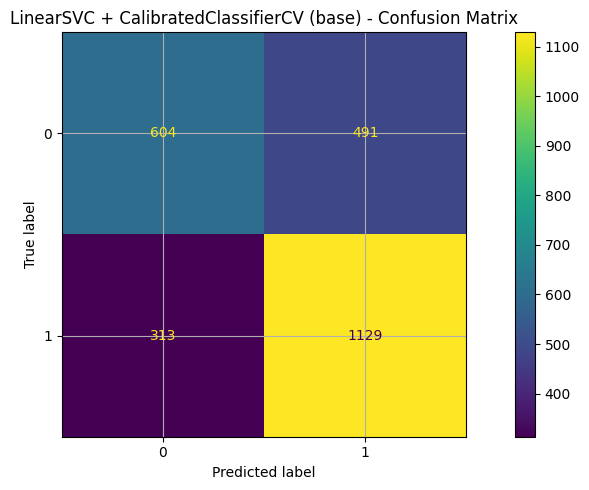

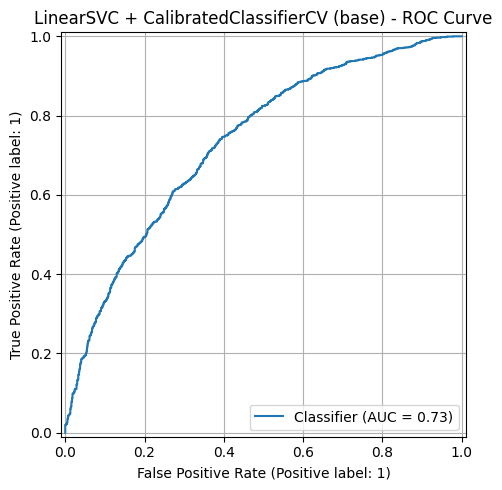

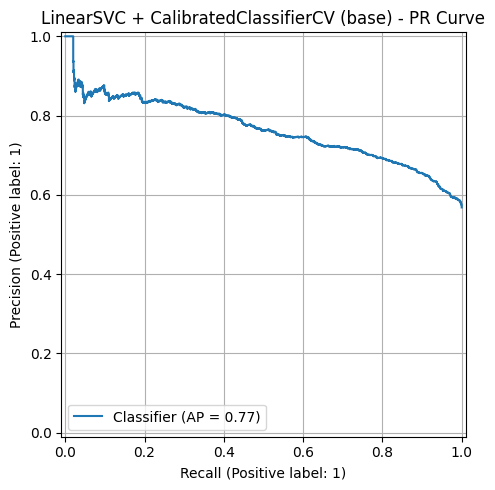

--- LinearSVC + CalibratedClassifierCV (base) Sonucu ---


,model,f1,roc_auc,pr_auc
0,LinearSVC + CalibratedClassifierCV (base),0.737427,0.732754,0.765163


In [16]:
name_svc = "LinearSVC + CalibratedClassifierCV (base)"
print(f"\nİşleniyor: {name_svc}...")

# Eğit ve Test Et
svc.fit(X_train, y_train)
result_svc = eval_on_test(svc, X_test, y_test, name_svc)

# Sadece bu modelin sonucunu göster
print(f"--- {name_svc} Sonucu ---")
display(pd.DataFrame([result_svc]))

**Reasoning**:
The next step is to define the RandomForest classifier pipeline, using the `preprocess_dense` ColumnTransformer as RandomForest models typically perform better with dense input.



In [17]:
random_forest_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf = Pipeline(steps=[
    ("preprocess", preprocess_dense),
    ("model", random_forest_model)
])

print("RandomForest pipeline 'rf' created.")

RandomForest pipeline 'rf' created.



İşleniyor: RandomForest (base)...

RandomForest (base)
F1=0.7933 | ROC-AUC=0.8202 | PR-AUC=0.8418
              precision    recall  f1-score   support

           0     0.7474    0.6457    0.6928      1095
           1     0.7561    0.8343    0.7933      1442

    accuracy                         0.7529      2537
   macro avg     0.7517    0.7400    0.7430      2537
weighted avg     0.7523    0.7529    0.7499      2537



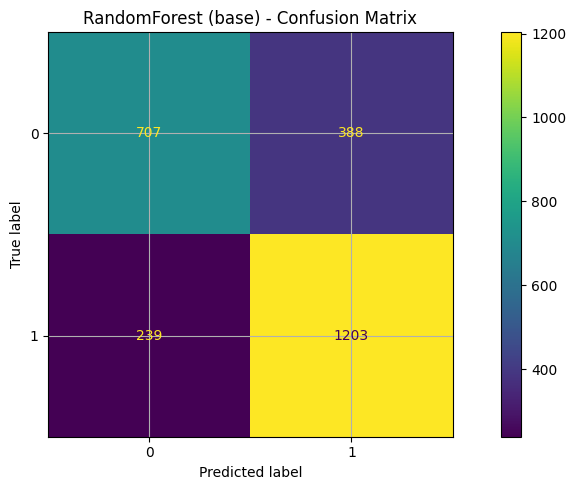

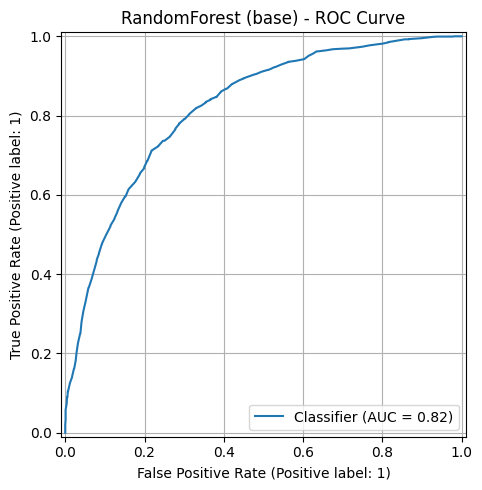

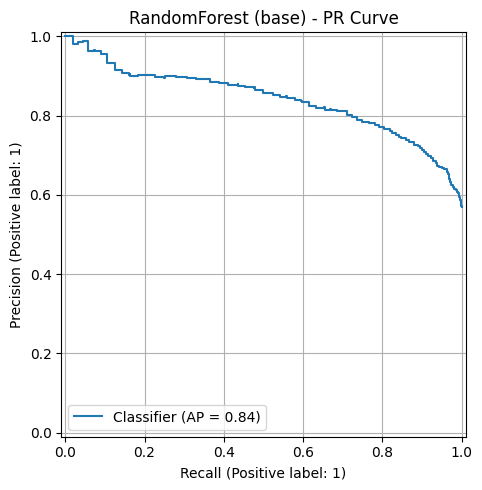

--- RandomForest (base) Sonucu ---


,model,f1,roc_auc,pr_auc
0,RandomForest (base),0.793274,0.820236,0.841778


In [18]:
name_rf = "RandomForest (base)"
print(f"\nİşleniyor: {name_rf}...")

# Eğit ve Test Et
rf.fit(X_train, y_train)
result_rf = eval_on_test(rf, X_test, y_test, name_rf)

# Sadece bu modelin sonucunu göster
print(f"--- {name_rf} Sonucu ---")
display(pd.DataFrame([result_rf]))

**Reasoning**:
Now that all three base models (Logistic Regression, LinearSVC, and RandomForest) have their pipelines defined, the next step is to fit these models on the training data and evaluate their performance on the test set using the `eval_on_test` function. This will generate the base performance metrics for comparison.



Yeni

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate

models = {
    "DummyClassifier": dummy,
    "LogisticRegression": lr,
    "LinearSVC+Calibrated": svc,
    "RandomForest": rf
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rows = []
for name, model in models.items():
    scores = cross_validate(
        model,
        X_train, y_train,
        cv=skf,
        scoring={"f1": "f1", "roc_auc": "roc_auc", "pr_auc": "average_precision"},
        n_jobs=-1,
        error_score=np.nan
    )
    rows.append({
        "model": name,
        "F1": scores["test_f1"].mean(),
        "ROC_AUC": scores["test_roc_auc"].mean(),
        "PR_AUC": scores["test_pr_auc"].mean()
    })

results = pd.DataFrame(rows).sort_values("ROC_AUC", ascending=False).reset_index(drop=True)
display(results)
print("En iyi (ROC_AUC):", results.loc[0, "model"])


,model,F1,ROC_AUC,PR_AUC
0,RandomForest,0.794683,0.826873,0.848721
1,LinearSVC+Calibrated,0.737090,0.737386,0.775848
2,LogisticRegression,0.734927,0.737335,0.776207
3,DummyClassifier,0.724851,0.500000,0.568444


En iyi (ROC_AUC): RandomForest


ikisi

In [20]:
import numpy as np
from scipy.stats import randint
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV

# CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 1) RANDOM SEARCH (geniş tarama)
param_dist = {
    "model__n_estimators": randint(100, 600),
    "model__max_depth": [None, 10, 20, 30, 40, 50],
    "model__min_samples_split": randint(2, 11),
    "model__min_samples_leaf": randint(1, 5),
    "model__max_features": ["sqrt"]
}

rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=cv,
    n_jobs=1,          # RAM güvenliği
    verbose=1,
    random_state=RANDOM_STATE,
    refit=False
)

rs.fit(X_train, y_train)
print("Random Search best score:", rs.best_score_)
print("Random Search best params:", rs.best_params_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Random Search best score: 0.8307190229339824
Random Search best params: {'model__max_depth': 30, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 559}


In [21]:
# 2) GRID SEARCH (bulunan bölge etrafında küçük grid)
best = rs.best_params_
best_n = best["model__n_estimators"]
best_d = best["model__max_depth"]
best_split = best["model__min_samples_split"]
best_leaf  = best["model__min_samples_leaf"]

grid_n = sorted(set([max(100, best_n - 50), best_n, best_n + 50]))
grid_split = sorted(set([max(2, best_split - 1), best_split, best_split + 1]))
grid_leaf  = sorted(set([max(1, best_leaf - 1), best_leaf, best_leaf + 1]))

if best_d is None:
    grid_depth = [None, 30]
else:
    grid_depth = sorted(set([max(5, best_d - 5), best_d, best_d + 5]))

fine_grid = {
    "model__n_estimators": grid_n,
    "model__max_depth": grid_depth,
    "model__min_samples_split": grid_split,
    "model__min_samples_leaf": grid_leaf,
    "model__max_features": ["sqrt"]
}

print("Grid:", fine_grid)

gs = GridSearchCV(
    estimator=rf,
    param_grid=fine_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=1,
    verbose=1,
    refit=True
)

gs.fit(X_train, y_train)

print("Grid Search best score:", gs.best_score_)
print("Grid Search best params:", gs.best_params_)

best_model = gs.best_estimator_

Grid: {'model__n_estimators': [509, 559, 609], 'model__max_depth': [25, 30, 35], 'model__min_samples_split': [2, 3], 'model__min_samples_leaf': [1, 2], 'model__max_features': ['sqrt']}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Grid Search best score: 0.8314232962804186
Grid Search best params: {'model__max_depth': 25, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 609}


In [22]:
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_validate

cv2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# base ve tuned (tuned = rf + gs.best_params_)
rf_base = rf
rf_tuned = clone(rf).set_params(**gs.best_params_)

models_2 = {
    "RF (base)": rf_base,
    "RF (tuned)": rf_tuned
}

rows = []
for name, model in models_2.items():
    out = cross_validate(
        model, X_train, y_train,
        cv=cv2,
        scoring={"f1": "f1", "roc_auc": "roc_auc", "pr_auc": "average_precision"},
        n_jobs=-1,
        error_score=np.nan
    )
    rows.append({
        "model": name,
        "F1_mean": out["test_f1"].mean(),
        "ROC_AUC_mean": out["test_roc_auc"].mean(),
        "PR_AUC_mean": out["test_pr_auc"].mean()
    })

results = pd.DataFrame(rows).sort_values("ROC_AUC_mean", ascending=False).reset_index(drop=True)
display(results)
print("En iyi (ROC_AUC_mean):", results.loc[0, "model"])


,model,F1_mean,ROC_AUC_mean,PR_AUC_mean
0,RF (tuned),0.800697,0.831423,0.855550
1,RF (base),0.794683,0.826873,0.848721


En iyi (ROC_AUC_mean): RF (tuned)


In [28]:
import joblib
joblib.dump(best_model, "best_model.joblib")
print("Model kaydedildi: best_model.joblib")


Model kaydedildi: best_model.joblib


/tmp/ipython-input-2563618788.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(top_n), palette='viridis')


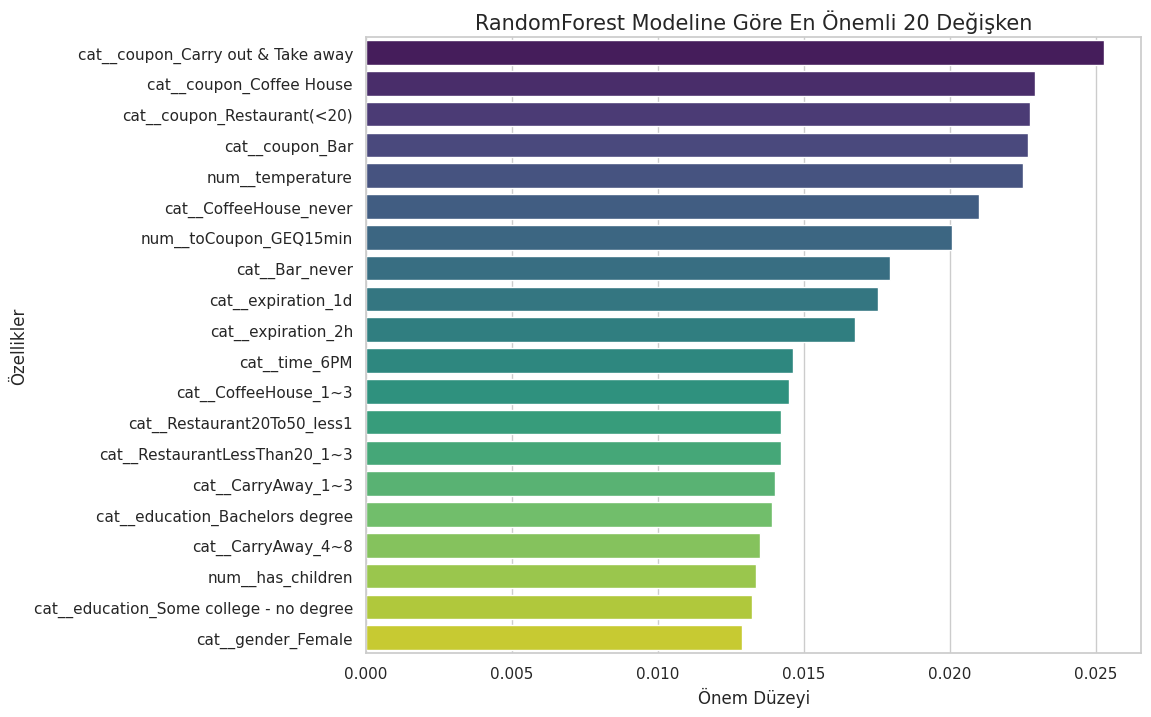

En önemli 10 özellik:


,Feature,Importance
23,cat__coupon_Carry out & Take away,0.025291
24,cat__coupon_Coffee House,0.022909
26,cat__coupon_Restaurant(<20),0.022758
22,cat__coupon_Bar,0.022686
0,num__temperature,0.022523
93,cat__CoffeeHouse_never,0.021014
3,num__toCoupon_GEQ15min,0.020064
88,cat__Bar_never,0.017934
27,cat__expiration_1d,0.017553
28,cat__expiration_2h,0.016747


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Modelin içinden önem derecelerini al
# Pipeline'ın son adımı (model) ve önceki adımları (preprocessor) ayrıştırılır
model_step = best_model.steps[-1][1]  # Son adım: RandomForest
preprocessor_step = best_model.steps[0][1] # İlk adım: Genelde Transformer/Preprocessor

# Feature Importance değerlerini al
importances = model_step.feature_importances_

# 2. Özellik İsimlerini Pipeline'dan Doğru Şekilde Çekme
try:
    # Modern Scikit-learn versiyonlarında (1.0+) bu özellik vardır
    # Pipeline'ın modelden önceki kısmından "dönüştürülmüş" isimleri isteriz
    feature_names = best_model[:-1].get_feature_names_out()
except AttributeError:
    # Eğer eski versiyon veya karmaşık bir yapı varsa hata verebilir.
    # Bu durumda "Feature_0", "Feature_1" gibi geçici isimler atarız ki kod çalışsın.
    print("UYARI: Orijinal sütun isimleri alınamadı (Encoding nedeniyle sayı değişti).")
    print(f"Model {len(importances)} özellik görüyor ama X_train {X_train.shape[1]} sütuna sahip.")
    feature_names = [f"Feature_{i}" for i in range(len(importances))]

# 3. DataFrame Oluşturma (Artık uzunluklar kesinlikle eşit)
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. Görselleştirme
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")

# İlk 20 özelliği göster
top_n = 20
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(top_n), palette='viridis')

plt.title(f'RandomForest Modeline Göre En Önemli {top_n} Değişken', fontsize=15)
plt.xlabel('Önem Düzeyi', fontsize=12)
plt.ylabel('Özellikler', fontsize=12)
plt.show()

# Sayısal liste
print("En önemli 10 özellik:")
display(feature_imp_df.head(10))

Threshold

OOF-CV ile seçilen threshold: 0.4618 | OOF F1: 0.8059

=== FINAL TEST (threshold train OOF ile seçildi) ===
Threshold=0.4618 | F1=0.8027 | ROC-AUC=0.8265 | PR-AUC=0.8491
              precision    recall  f1-score   support

           0     0.7871    0.5909    0.6750      1095
           1     0.7388    0.8786    0.8027      1442

    accuracy                         0.7544      2537
   macro avg     0.7629    0.7348    0.7388      2537
weighted avg     0.7596    0.7544    0.7476      2537



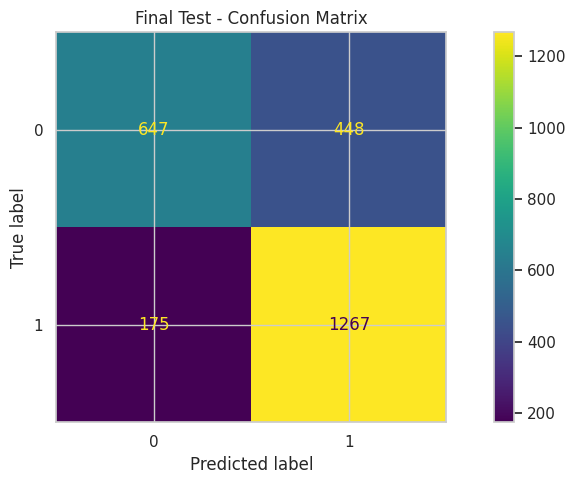

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    precision_recall_curve, f1_score,
    roc_auc_score, average_precision_score,
    classification_report, ConfusionMatrixDisplay
)

def get_scores(estimator, X):
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    return estimator.decision_function(X)

def best_threshold_by_f1(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    # thresholds uzunluğu n-1; bu yüzden precision/recall'ın son elemanını atıyoruz
    f1s = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)
    idx = np.argmax(f1s)
    return thresholds[idx], f1s[idx]

# -------------------------------------------------
# 1) Threshold'u TRAIN içinde OOF-CV ile seç
# -------------------------------------------------
model_for_threshold = best_model   # ör: gs.best_estimator_ (tuned RF) veya seçtiğin model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
method = "predict_proba" if hasattr(model_for_threshold, "predict_proba") else "decision_function"

oof = cross_val_predict(model_for_threshold, X_train, y_train, cv=skf, method=method, n_jobs=-1)
if method == "predict_proba":
    oof = oof[:, 1]

best_thr, oof_best_f1 = best_threshold_by_f1(y_train, oof)
print(f"OOF-CV ile seçilen threshold: {best_thr:.4f} | OOF F1: {oof_best_f1:.4f}")

# -------------------------------------------------
# 2) Final: full TRAIN fit (1 kere)
# -------------------------------------------------
model_for_threshold.fit(X_train, y_train)

# -------------------------------------------------
# 3) TEST: sadece 1 kere raporla
# -------------------------------------------------
test_score = get_scores(model_for_threshold, X_test)
y_pred_test = (test_score >= best_thr).astype(int)

f1 = f1_score(y_test, y_pred_test)
roc = roc_auc_score(y_test, test_score)
pr  = average_precision_score(y_test, test_score)

print("\n=== FINAL TEST (threshold train OOF ile seçildi) ===")
print(f"Threshold={best_thr:.4f} | F1={f1:.4f} | ROC-AUC={roc:.4f} | PR-AUC={pr:.4f}")
print(classification_report(y_test, y_pred_test, digits=4, zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.title("Final Test - Confusion Matrix")
plt.tight_layout()
plt.show()
